# Regularization for a classifier of the cat/dog data

## Plot functions for training evaluation
This function will provide performance curves for each epoch of the training process. This will allow us later to judge if overfitting occured or not and if our regularization approaches were successful.

In [10]:
import matplotlib.pyplot as plt

def plot_histories(histories, keys=['loss', 'acc']):
    fig, axs = plt.subplots(len(keys), 1, figsize=(20,16))
    #fig.figsize=(20,16)
    if len(keys) == 1:
        axs = [axs]
    # one plot for each specified key
    for i, ax in enumerate(axs):
        key = keys[i]
        for name, history in histories:
            val = ax.plot(history.epoch, history.history['val_'+key],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history[key], color=val[0].get_color(),
                    label=name.title()+' Train')

        ax.set_xlabel('Epochs')
        ax.set_ylabel(key.replace('_',' ').title())
        ax.legend()
        ax.set_title(key)
        ax.set_xlim([0,max(history.epoch)])
    plt.show()

## Setting input paths

In [11]:
import numpy as np

In [12]:
import os

os.getcwd()

'/lustre/projects/icarus/39/dlbc18/day2/regularization/notebook'

In [13]:
# TODO: maybe have to adjust the base_dir if IO error occurs
base_dir = os.path.join('..','..', '..', 'data','cats-dogs')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [14]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total validation dog images: 400


## Setting up the input pipeline 

In [15]:
# this is the augmentation configuration we will use for training
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
batch_size = 64

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## The baseline model
Our first model whose performance we will try to improve by means of regularization.
We will see that it is powerful enough to classify the training data perfectly. But this is of course not our main goal. So maybe it is already to powerful (in terms of parameters)?

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def get_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [19]:
m_base = get_baseline_model()
#m_base = get_baseline_model_cnn()
print(m_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [20]:
from keras import optimizers

m_base.compile(optimizer='rmsprop',
               loss="binary_crossentropy", 
               metrics=['accuracy'])

## Start training

In [21]:
epochs = 20

hist_base = m_base.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 528ms/step - loss: 0.7107 - acc: 0.5337 - val_loss: 0.7076 - val_acc: 0.4987
Epoch 2/20
31/31 [==============================] - 16s 515ms/step - loss: 0.6828 - acc: 0.5880 - val_loss: 0.6850 - val_acc: 0.5677
Epoch 3/20
31/31 [==============================] - 16s 508ms/step - loss: 0.6468 - acc: 0.6406 - val_loss: 0.6368 - val_acc: 0.6953
Epoch 4/20
31/31 [==============================] - 15s 494ms/step - loss: 0.5846 - acc: 0.6894 - val_loss: 0.6052 - val_acc: 0.6719
Epoch 5/20
31/31 [==============================] - 15s 483ms/step - loss: 0.5538 - acc: 0.7384 - val_loss: 0.6095 - val_acc: 0.6589
Epoch 6/20
31/31 [==============================] - 14s 465ms/step - loss: 0.5044 - acc: 0.7567 - val_loss: 0.6252 - val_acc: 0.6797
Epoch 7/20
31/31 [==============================] - 14s 458ms/step - loss: 0.4532 - acc: 0.7893 - val_loss: 0.7091 - val_acc: 0.6940
Epoch 8/20
31/31 [==============================] - 14s 447ms/step - 

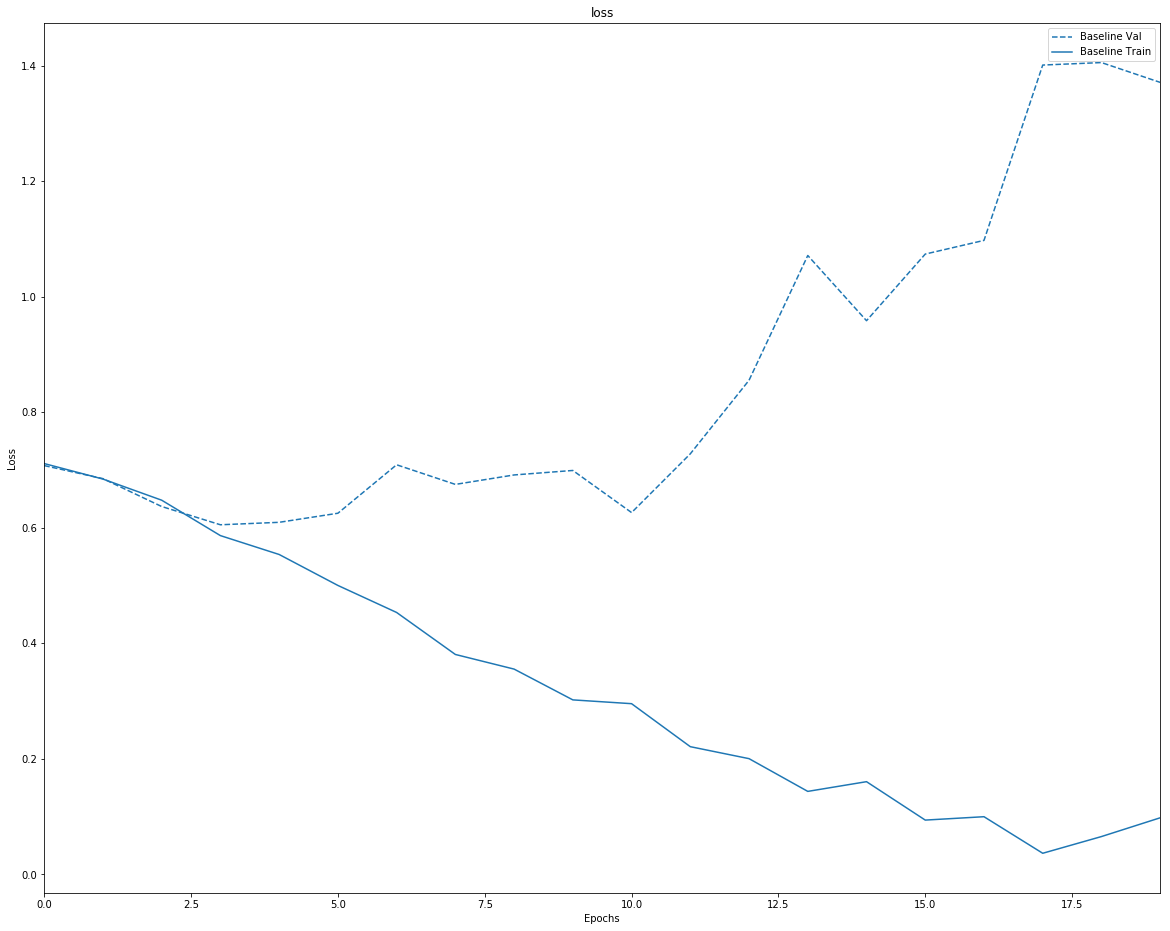

In [22]:
plot_histories([('baseline', hist_base)], keys=['loss'])

# Adjust model size

## smaller model

Since the baseline model is able to classify the training data almost perfectly, we will try to lessen its capacity by reducing the number of parameters, hoping to reduce the amount of overfitting. 


In [23]:
def get_smaller_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # conv block with only half as many filters
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [24]:
m_small = get_smaller_model()
print(m_small.summary())

m_small.compile(optimizer='rmsprop',
               loss="binary_crossentropy", 
               metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_17 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 32)        9248      
__________

In [25]:
hist_small = m_small.fit_generator(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch=2000 // batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 17s 533ms/step - loss: 0.7448 - acc: 0.5132 - val_loss: 0.6728 - val_acc: 0.5495
Epoch 2/20
31/31 [==============================] - 16s 508ms/step - loss: 0.6860 - acc: 0.5983 - val_loss: 0.6300 - val_acc: 0.7057
Epoch 3/20
31/31 [==============================] - 16s 506ms/step - loss: 0.6241 - acc: 0.6499 - val_loss: 0.5633 - val_acc: 0.7188
Epoch 4/20
31/31 [==============================] - 15s 495ms/step - loss: 0.5779 - acc: 0.7061 - val_loss: 0.5447 - val_acc: 0.7331
Epoch 5/20
31/31 [==============================] - 15s 485ms/step - loss: 0.5504 - acc: 0.7263 - val_loss: 0.6756 - val_acc: 0.6055
Epoch 6/20
31/31 [==============================] - 15s 478ms/step - loss: 0.4993 - acc: 0.7460 - val_loss: 0.5402 - val_acc: 0.7539
Epoch 7/20
31/31 [==============================] - 14s 461ms/step - loss: 0.4647 - acc: 0.7712 - val_loss: 0.6620 - val_acc: 0.6523
Epoch 8/20
31/31 [==============================] - 14s 454ms/step - 

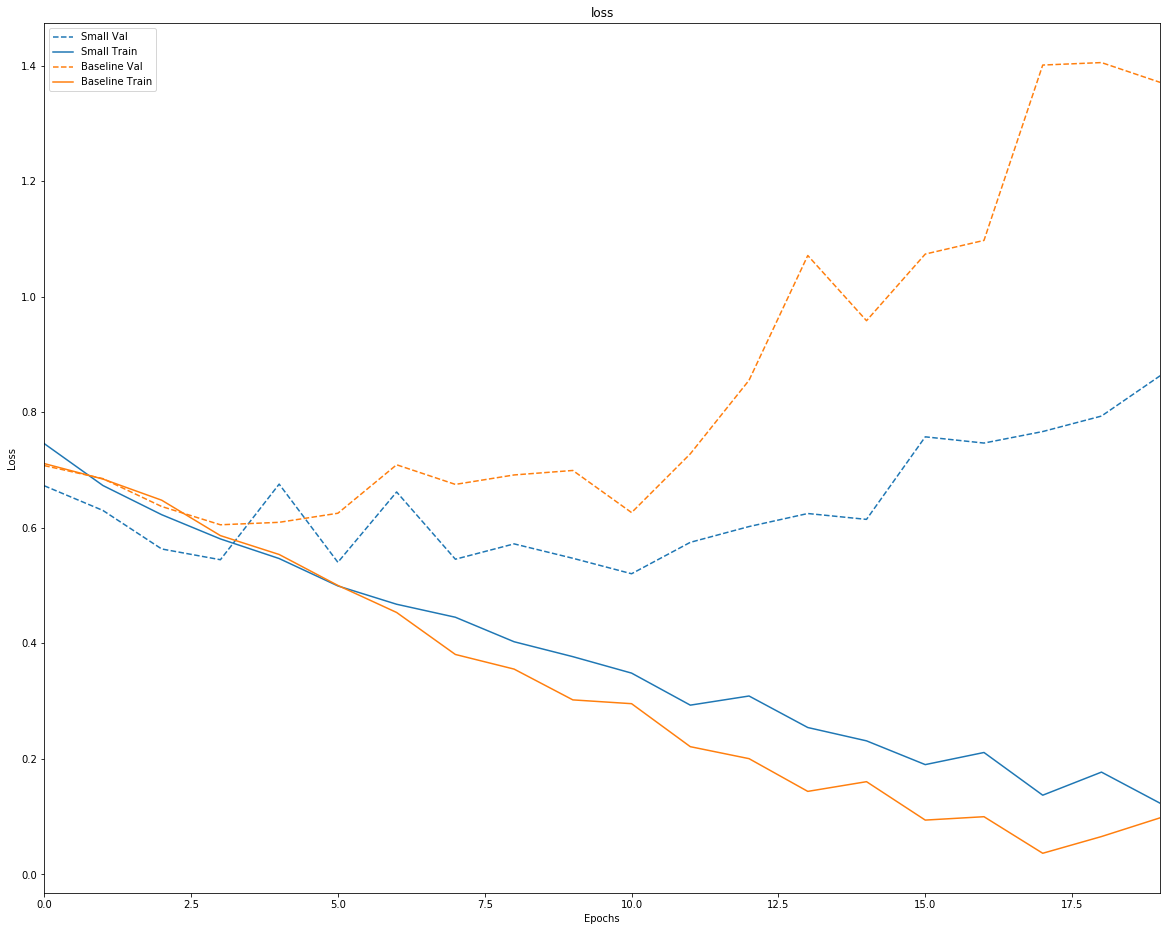

In [26]:
plot_histories([('small', hist_small),
                ('baseline', hist_base), ], keys=['loss'])

## larger model

By making the model larger we expect to see an even more extreme form of overfitting.

In [13]:
def get_larger_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    # twice as many fc neurons here!
    model.add(Dense(128))
    model.add(Activation('relu'))
    # and another dense layer!
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [14]:
m_large = get_larger_model()
print(m_large.summary())

m_large.compile(optimizer='rmsprop',
                loss="binary_crossentropy", 
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [15]:
hist_large = m_large.fit_generator(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch=2000 // batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 520ms/step - loss: 0.7585 - acc: 0.4879 - val_loss: 0.6877 - val_acc: 0.5430
Epoch 2/20
31/31 [==============================] - 16s 510ms/step - loss: 0.6986 - acc: 0.5389 - val_loss: 0.6861 - val_acc: 0.5820
Epoch 3/20
31/31 [==============================] - 16s 501ms/step - loss: 0.6809 - acc: 0.6063 - val_loss: 0.6232 - val_acc: 0.6875
Epoch 4/20
31/31 [==============================] - 15s 490ms/step - loss: 0.6183 - acc: 0.6563 - val_loss: 0.8163 - val_acc: 0.5326
Epoch 5/20
31/31 [==============================] - 15s 480ms/step - loss: 0.5931 - acc: 0.6875 - val_loss: 0.5919 - val_acc: 0.6849
Epoch 6/20
31/31 [==============================] - 15s 470ms/step - loss: 0.5655 - acc: 0.7203 - val_loss: 0.6072 - val_acc: 0.6823
Epoch 7/20
31/31 [==============================] - 14s 462ms/step - loss: 0.4952 - acc: 0.7626 - val_loss: 0.5902 - val_acc: 0.7070
Epoch 8/20
31/31 [==============================] - 14s 459ms/step - 

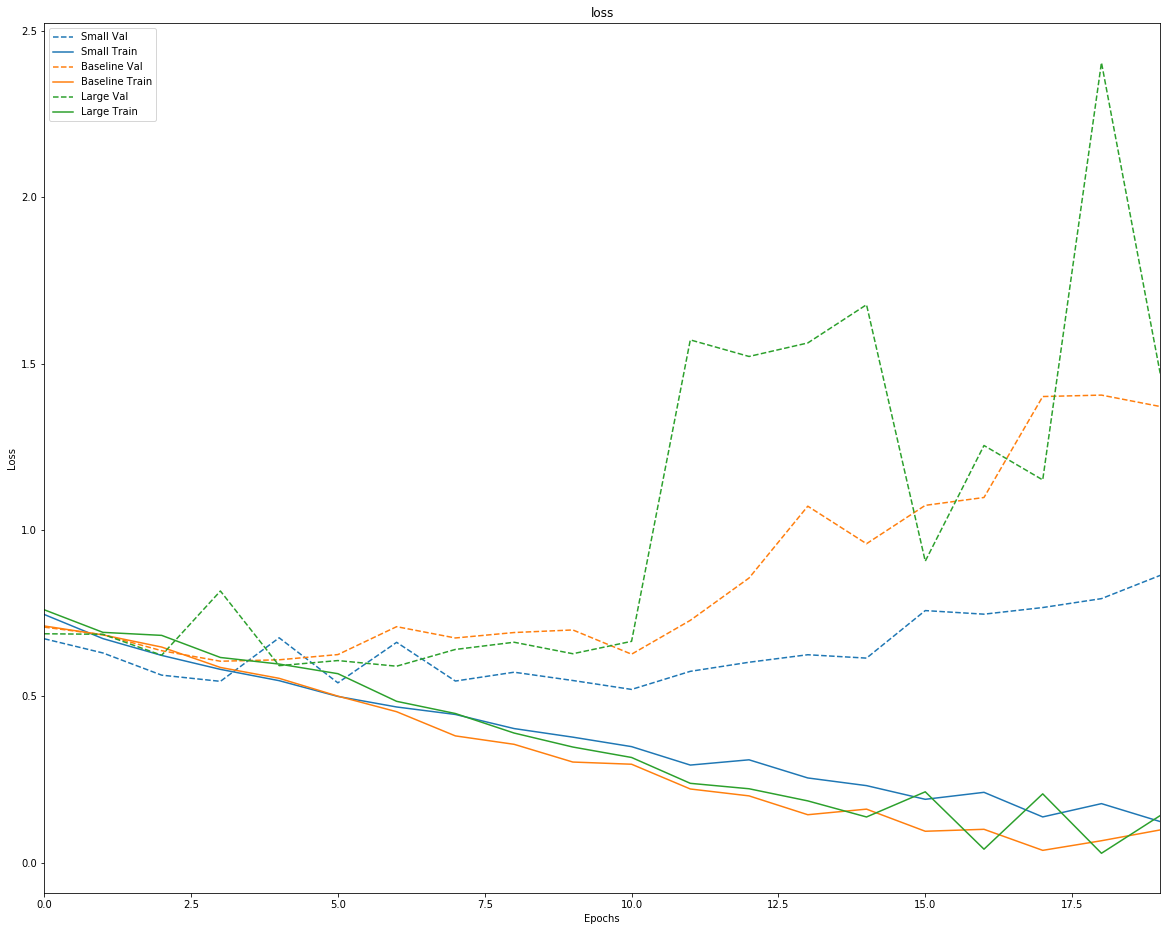

In [27]:
plot_histories([('small', hist_small),
                ('baseline', hist_base), 
                ('large', hist_large)], keys=['loss'])

## Using "early stopping"

The idea here is to stop the training procedure before the model starts to adapt too much on the training samples. We go on as long as the validation loss drops by at least 0.1 and stop if it does not do so during 5 consecutive training epochs.

Note: This is a kind of data snooping since information of the validation set is used during training which should in general be a no-go. We show it here for demonstration only! The way to go would be to divide your data into training, validation and test set and do the early stopping based on the loss on the validation set. After the model is then trained, you should validate it on the test set which has not been looked at before.

In [28]:
from keras.callbacks import EarlyStopping

m_base = get_baseline_model()

m_base.compile(optimizer="rmsprop",
               #optimizers.Adadelta(),
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_earlystop = m_base.fit_generator(train_generator,
                                      epochs=epochs,
                                      steps_per_epoch=2000 // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=800 // batch_size,
                                      callbacks=[
                                          EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=1)])

Epoch 1/20
31/31 [==============================] - 16s 526ms/step - loss: 0.9056 - acc: 0.5388 - val_loss: 0.6770 - val_acc: 0.5573
Epoch 2/20
31/31 [==============================] - 16s 511ms/step - loss: 0.6827 - acc: 0.5907 - val_loss: 0.6715 - val_acc: 0.5703
Epoch 3/20
31/31 [==============================] - 16s 513ms/step - loss: 0.6421 - acc: 0.6497 - val_loss: 0.6021 - val_acc: 0.6654
Epoch 4/20
31/31 [==============================] - 15s 493ms/step - loss: 0.6024 - acc: 0.6709 - val_loss: 0.6347 - val_acc: 0.6146
Epoch 5/20
31/31 [==============================] - 15s 492ms/step - loss: 0.5782 - acc: 0.6981 - val_loss: 0.6316 - val_acc: 0.6263
Epoch 6/20
31/31 [==============================] - 14s 466ms/step - loss: 0.5360 - acc: 0.7236 - val_loss: 0.7048 - val_acc: 0.5924
Epoch 00006: early stopping


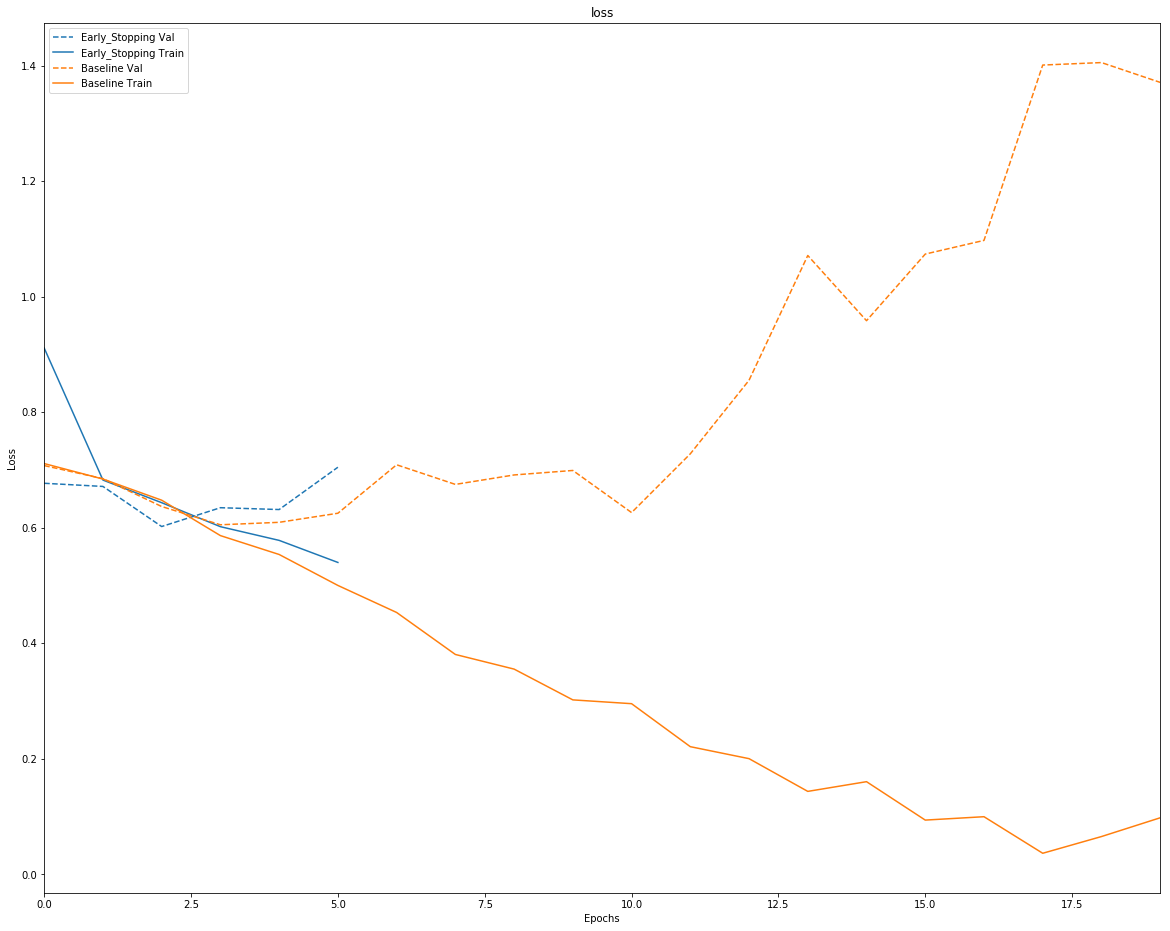

In [29]:
plot_histories([('early_stopping', hist_earlystop), 
                ('baseline', hist_base)], keys=['loss'])

## Weight regularisation

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's try both flavors now.

### Using L1 regularization

In [30]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l1_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(reg_weight), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Activation('sigmoid'))
    
    return model

```l1(0.001)``` means that every coefficient in the weight matrix of the layer will add ```0.001 * abs(weight_coefficient_value)``` to the total loss of the network.

In [31]:
m_l1 = get_l1_model()

m_l1.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_l1 = m_l1.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 530ms/step - loss: 1.3001 - acc: 0.5182 - val_loss: 0.9740 - val_acc: 0.4987
Epoch 2/20
31/31 [==============================] - 16s 522ms/step - loss: 0.9019 - acc: 0.5085 - val_loss: 0.8433 - val_acc: 0.5052
Epoch 3/20
31/31 [==============================] - 16s 507ms/step - loss: 0.8294 - acc: 0.5152 - val_loss: 0.8053 - val_acc: 0.5013
Epoch 4/20
31/31 [==============================] - 15s 495ms/step - loss: 0.7983 - acc: 0.5074 - val_loss: 0.7891 - val_acc: 0.4987
Epoch 5/20
31/31 [==============================] - 15s 483ms/step - loss: 0.7902 - acc: 0.5515 - val_loss: 0.7810 - val_acc: 0.5273
Epoch 6/20
31/31 [==============================] - 15s 472ms/step - loss: 0.7806 - acc: 0.5556 - val_loss: 0.7675 - val_acc: 0.6016
Epoch 7/20
31/31 [==============================] - 14s 457ms/step - loss: 0.7645 - acc: 0.5659 - val_loss: 0.7502 - val_acc: 0.6250
Epoch 8/20
31/31 [==============================] - 14s 444ms/step - 

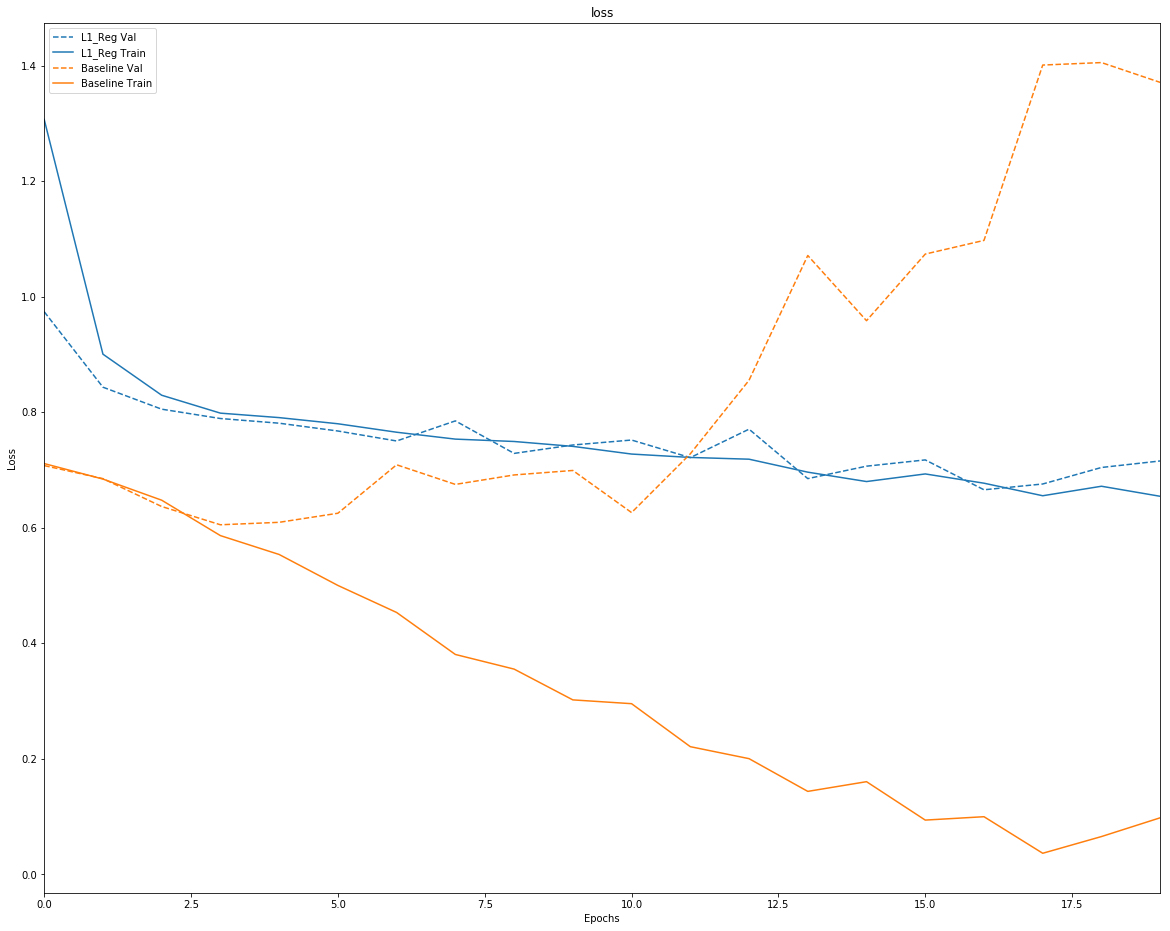

In [32]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base)], keys=['loss'])

Note that because this penalty is only added at training time, the loss for this network will be higher at training than at test time.


### Using L2 regularization

In [33]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(reg_weight), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Activation('sigmoid'))
    return model

In [34]:
m_l2 = get_l2_model()

m_l2.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_l2 = m_l2.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=2000 // batch_size,
                             validation_data=validation_generator,
                             validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 526ms/step - loss: 0.8340 - acc: 0.5052 - val_loss: 0.7058 - val_acc: 0.4987
Epoch 2/20
31/31 [==============================] - 16s 517ms/step - loss: 0.7018 - acc: 0.5564 - val_loss: 0.6826 - val_acc: 0.5586
Epoch 3/20
31/31 [==============================] - 16s 507ms/step - loss: 0.6719 - acc: 0.6215 - val_loss: 0.6368 - val_acc: 0.6393
Epoch 4/20
31/31 [==============================] - 15s 492ms/step - loss: 0.6560 - acc: 0.6446 - val_loss: 0.6591 - val_acc: 0.6198
Epoch 5/20
31/31 [==============================] - 15s 485ms/step - loss: 0.6069 - acc: 0.6874 - val_loss: 0.8636 - val_acc: 0.5404
Epoch 6/20
31/31 [==============================] - 15s 474ms/step - loss: 0.5725 - acc: 0.7216 - val_loss: 0.5854 - val_acc: 0.7005
Epoch 7/20
31/31 [==============================] - 14s 461ms/step - loss: 0.5473 - acc: 0.7231 - val_loss: 0.5993 - val_acc: 0.6901
Epoch 8/20
31/31 [==============================] - 14s 456ms/step - 

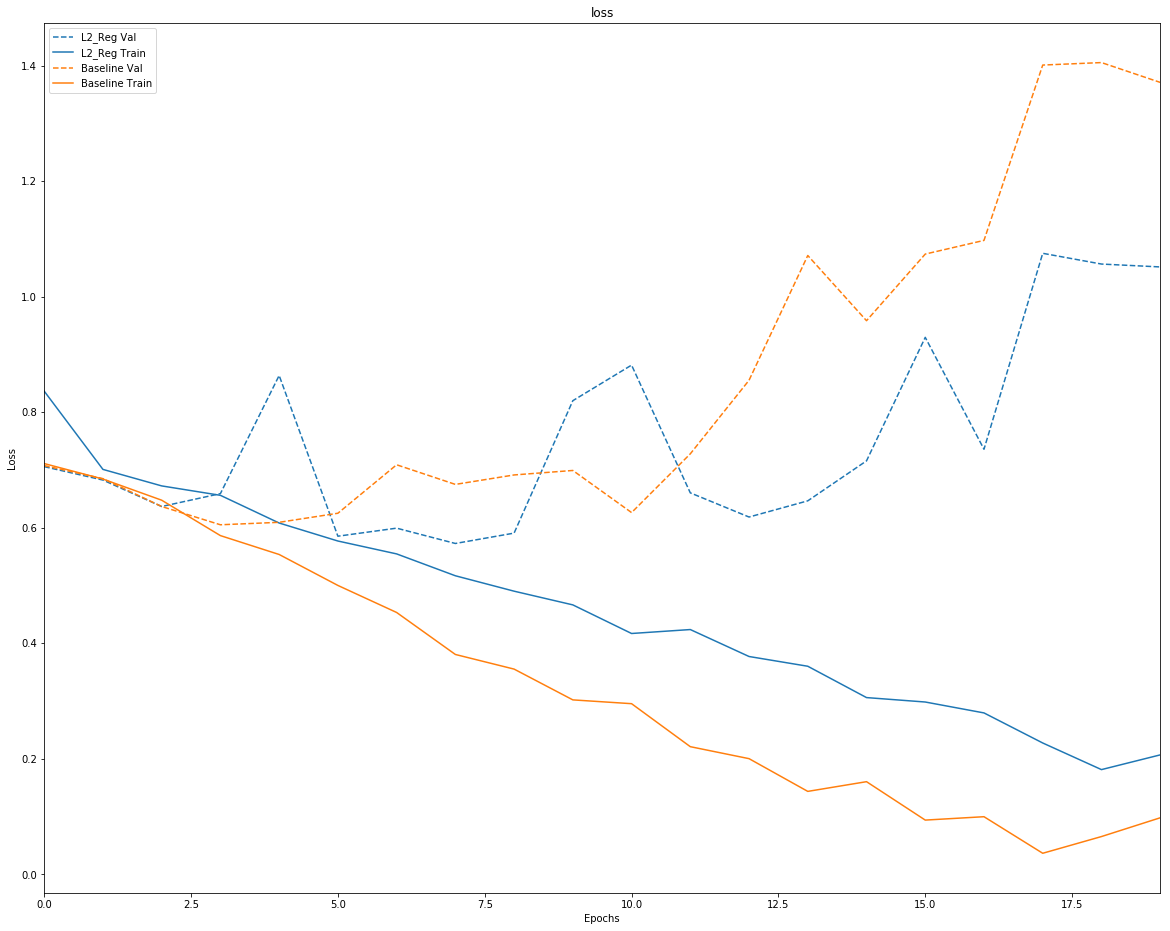

In [35]:
plot_histories([('l2_reg', hist_l2), 
                ('baseline', hist_base)], keys=['loss'])

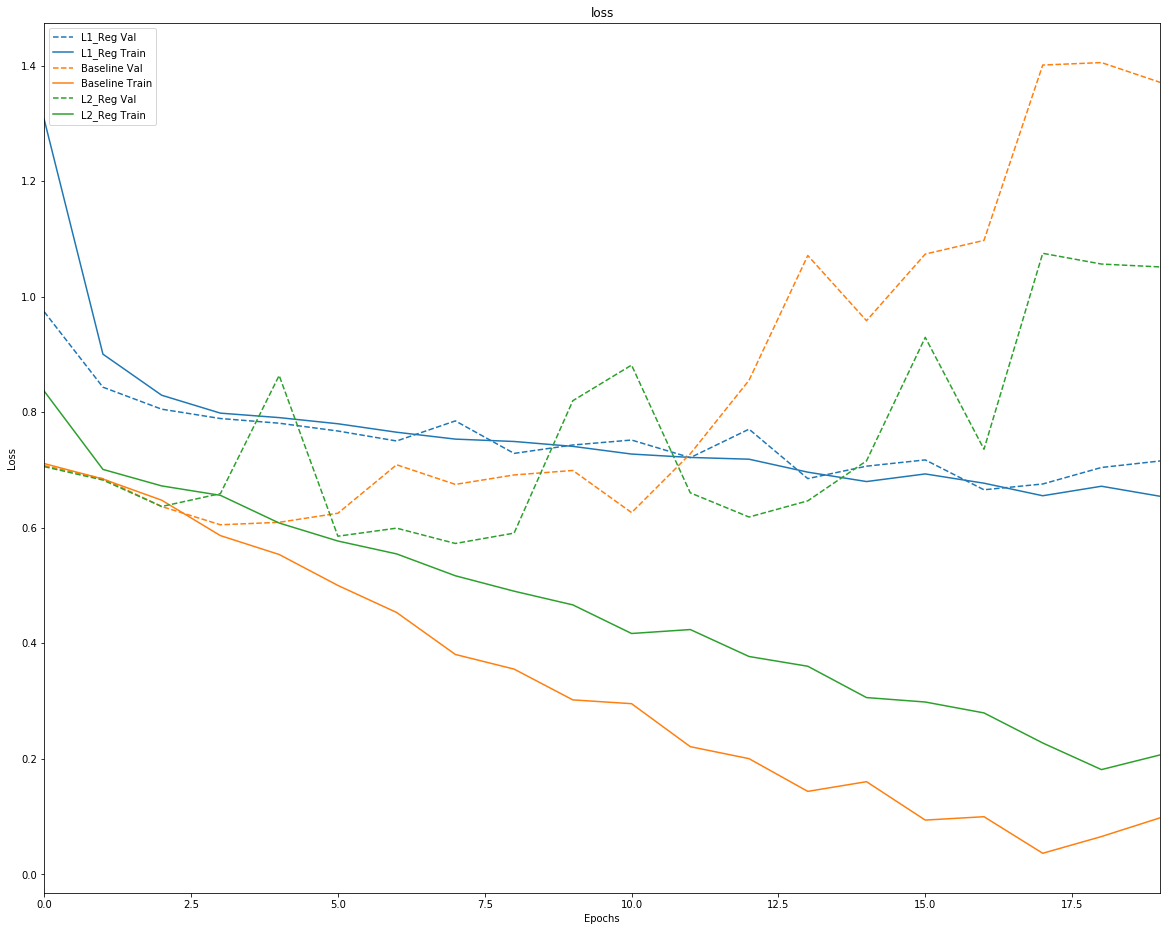

In [36]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base),
                ('l2_reg', hist_l2)], keys=['loss'])

### Using L1 and L2 regularization

In [37]:
reg_weight = 1.e-4

def get_l1_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight), 
                     input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Activation('sigmoid'))

    
    return model

In [38]:
m_l1l2 = get_l1_l2_model()

m_l1l2.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_l1l2 = m_l1l2.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 526ms/step - loss: 1.2064 - acc: 0.5215 - val_loss: 0.9461 - val_acc: 0.5169
Epoch 2/20
31/31 [==============================] - 16s 517ms/step - loss: 0.9032 - acc: 0.5423 - val_loss: 0.8414 - val_acc: 0.5964
Epoch 3/20
31/31 [==============================] - 16s 507ms/step - loss: 0.8236 - acc: 0.5436 - val_loss: 0.8096 - val_acc: 0.6224
Epoch 4/20
31/31 [==============================] - 15s 497ms/step - loss: 0.8066 - acc: 0.5736 - val_loss: 0.7813 - val_acc: 0.5833
Epoch 5/20
31/31 [==============================] - 15s 484ms/step - loss: 0.7753 - acc: 0.5973 - val_loss: 0.7833 - val_acc: 0.6107
Epoch 6/20
31/31 [==============================] - 15s 475ms/step - loss: 0.7678 - acc: 0.6175 - val_loss: 0.7775 - val_acc: 0.5768
Epoch 7/20
31/31 [==============================] - 15s 477ms/step - loss: 0.7422 - acc: 0.6457 - val_loss: 0.7303 - val_acc: 0.6654
Epoch 8/20
31/31 [==============================] - 14s 451ms/step - 

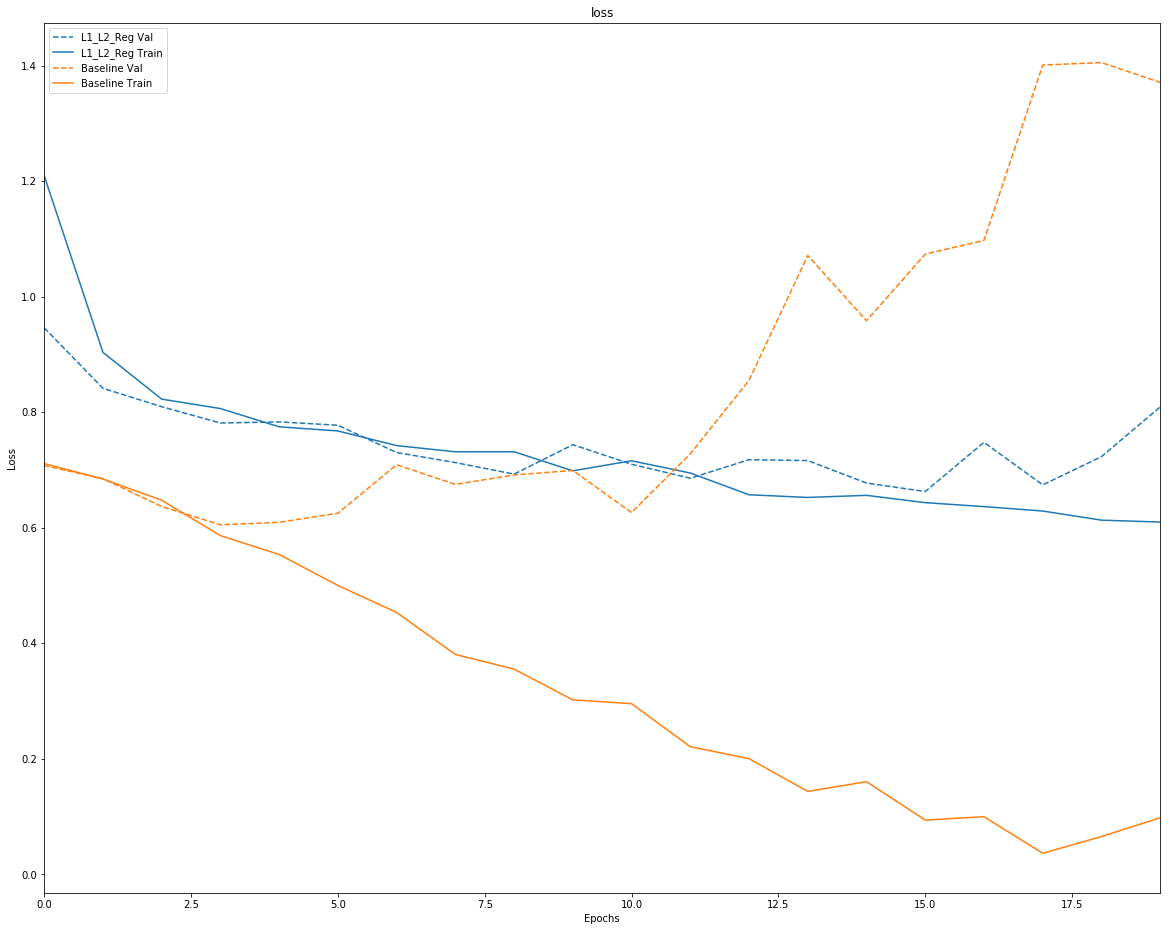

In [39]:
plot_histories([('l1_l2_reg', hist_l1l2), 
                ('baseline', hist_base)], keys=['loss'])

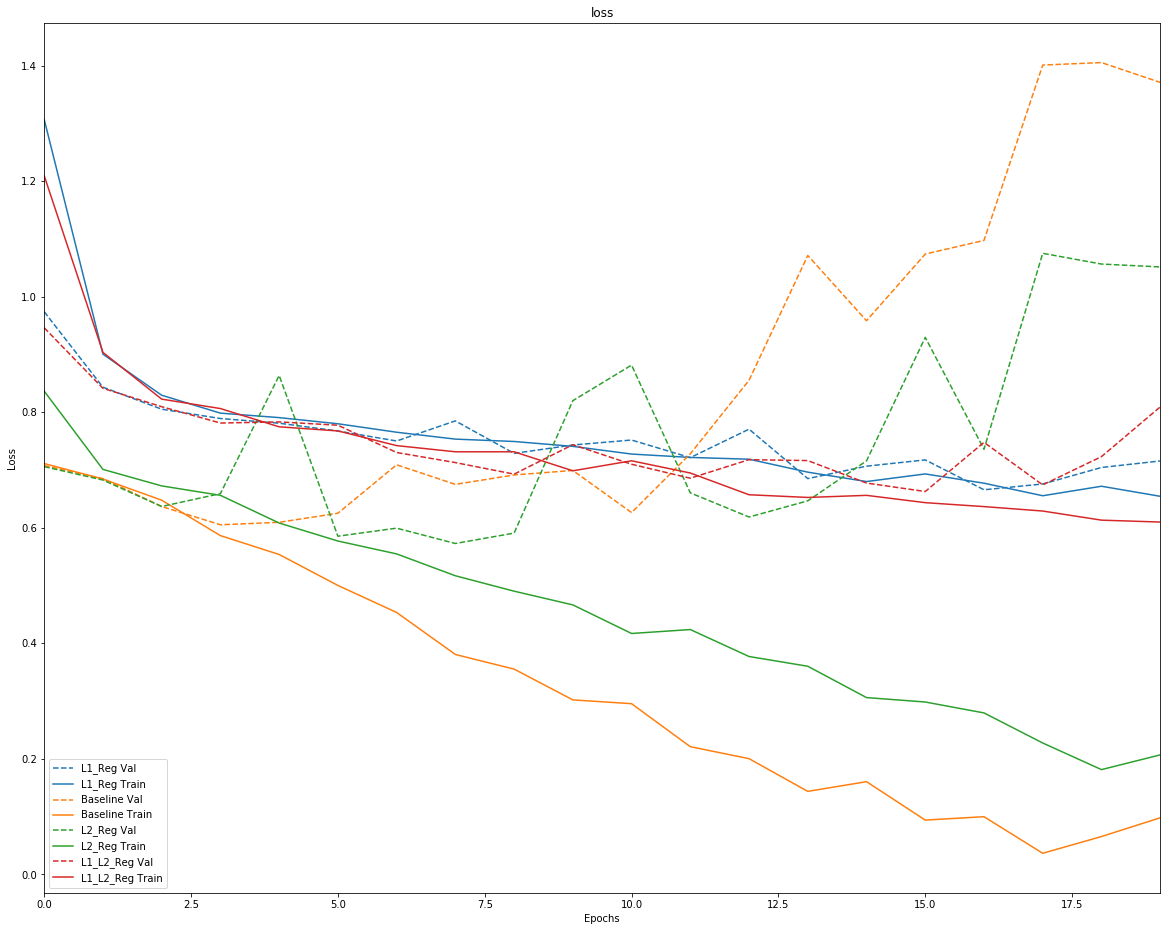

In [40]:
plot_histories([('l1_reg', hist_l1), 
                ('baseline', hist_base),
                ('l2_reg', hist_l2),
                ('l1_l2_reg', hist_l1l2)], keys=['loss'])

## Using dropout

Dropout is one of the most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 
1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.


In [41]:
from keras.layers import Dropout

def get_dropout_model(rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [42]:
m_drop = get_dropout_model()

m_drop.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_drop = m_drop.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=2000 // batch_size,
                                 validation_data=validation_generator,
                                 validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 531ms/step - loss: 0.7018 - acc: 0.5151 - val_loss: 0.6817 - val_acc: 0.5104
Epoch 2/20
31/31 [==============================] - 16s 516ms/step - loss: 0.6706 - acc: 0.5909 - val_loss: 0.6402 - val_acc: 0.6576
Epoch 3/20
31/31 [==============================] - 16s 509ms/step - loss: 0.6331 - acc: 0.6391 - val_loss: 0.6330 - val_acc: 0.6276
Epoch 4/20
31/31 [==============================] - 15s 493ms/step - loss: 0.5913 - acc: 0.6903 - val_loss: 0.6122 - val_acc: 0.6562
Epoch 5/20
31/31 [==============================] - 15s 494ms/step - loss: 0.5762 - acc: 0.6996 - val_loss: 0.5731 - val_acc: 0.7083
Epoch 6/20
31/31 [==============================] - 15s 489ms/step - loss: 0.5271 - acc: 0.7359 - val_loss: 0.6349 - val_acc: 0.7018
Epoch 7/20
31/31 [==============================] - 14s 462ms/step - loss: 0.5410 - acc: 0.7390 - val_loss: 0.5597 - val_acc: 0.7305
Epoch 8/20
31/31 [==============================] - 14s 454ms/step - 

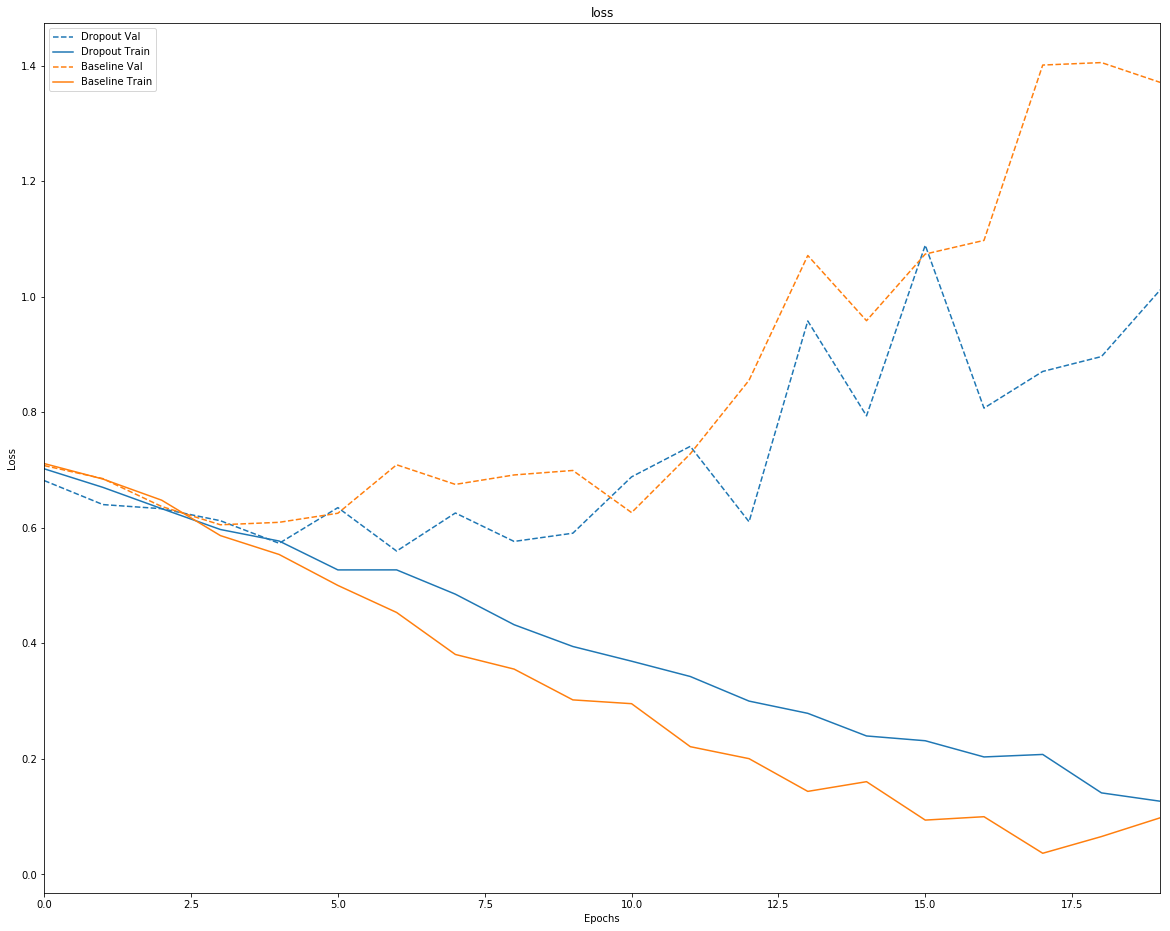

In [43]:
plot_histories([('dropout', hist_drop), 
                ('baseline', hist_base)], keys=['loss'])

Let's investigate the effect of a higher dropout rate.

In [44]:
m_more_drop = get_dropout_model(0.75)
m_more_drop.compile(optimizer="rmsprop",
                    loss="binary_crossentropy", 
                    metrics=['accuracy'])

hist_more_drop = m_more_drop.fit_generator(train_generator,
                                           epochs=epochs,
                                           steps_per_epoch=2000 // batch_size,
                                           validation_data=validation_generator,
                                           validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 528ms/step - loss: 0.7997 - acc: 0.4749 - val_loss: 0.6910 - val_acc: 0.5885
Epoch 2/20
31/31 [==============================] - 16s 527ms/step - loss: 0.6862 - acc: 0.5680 - val_loss: 0.6781 - val_acc: 0.6159
Epoch 3/20
31/31 [==============================] - 16s 505ms/step - loss: 0.6752 - acc: 0.5951 - val_loss: 0.6613 - val_acc: 0.6849
Epoch 4/20
31/31 [==============================] - 15s 495ms/step - loss: 0.6585 - acc: 0.6262 - val_loss: 0.6240 - val_acc: 0.6628
Epoch 5/20
31/31 [==============================] - 15s 489ms/step - loss: 0.6713 - acc: 0.6720 - val_loss: 0.6122 - val_acc: 0.6510
Epoch 6/20
31/31 [==============================] - 15s 475ms/step - loss: 0.5567 - acc: 0.7253 - val_loss: 0.7679 - val_acc: 0.6198
Epoch 7/20
31/31 [==============================] - 14s 466ms/step - loss: 0.5544 - acc: 0.7279 - val_loss: 0.6669 - val_acc: 0.6055
Epoch 8/20
31/31 [==============================] - 14s 457ms/step - 

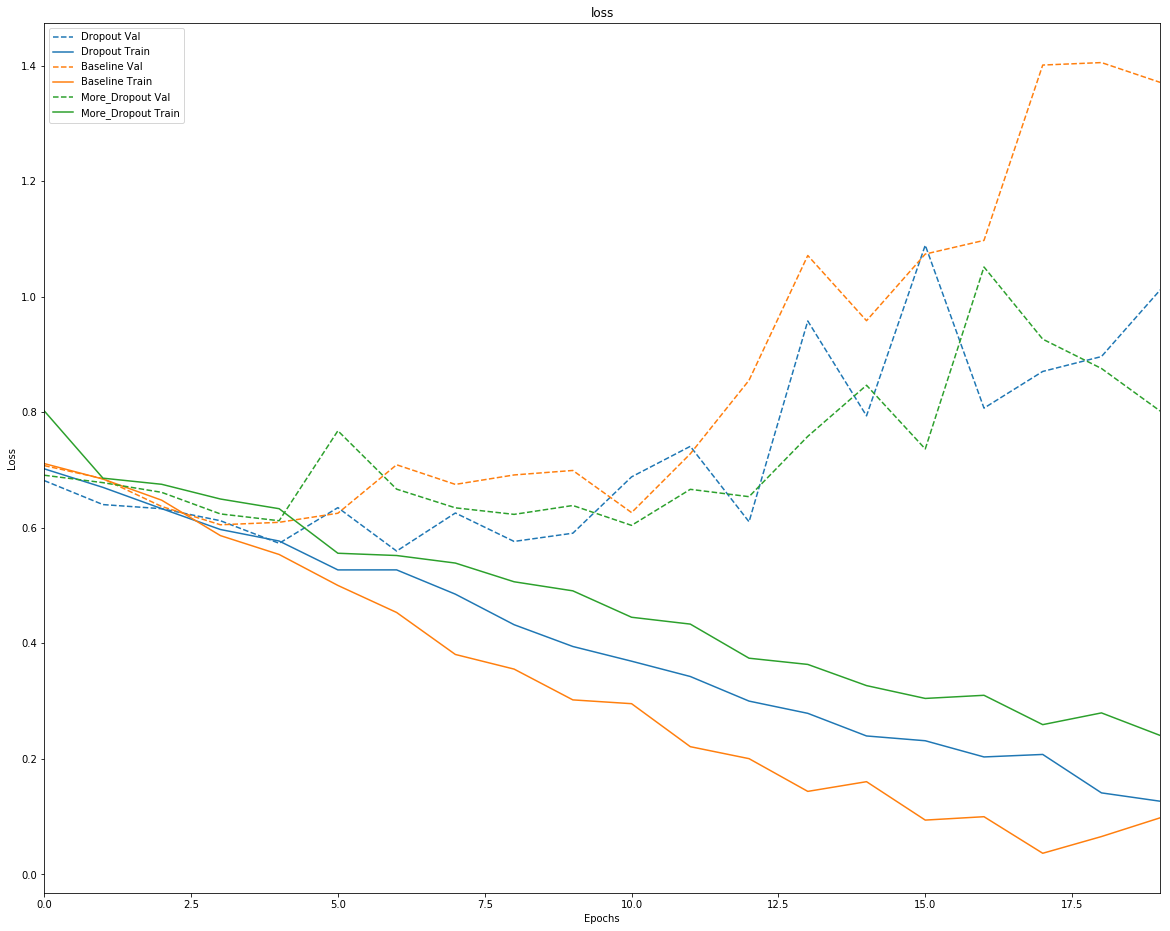

In [45]:
plot_histories([('dropout', hist_drop), 
                ('baseline', hist_base),
                ('more_dropout', hist_more_drop)], keys=['loss'])

## Using batch normalization

Intuitively you want the variances of each layers input of your network to be nice. You do not want them to go to zero nor do you want them to explode. Ideally you want everything be normalized throughout your network. 
Batch normalization is a new technique that does this: it just takes the batch mean and standard deviation of each of our features (i.e. for each pixel across the data) and then sets its value to be such that it has zero mean and unit variance.

It turns out that this function is differentiable and we can backpropagate it! By inserting now a batch normalization layer in our network we will take in as input some x and normalize it. So for a given input activation we can apply this normalization independently across our batch. So the hope is that by doing this the network will learn faster because it will not have to adapt to changes in the distribution of the inputs it receives.

Benefits of BN

- Improves gradient flow through network
- Allow higher learning rates
- Reduce strong dependency on initialization
- Acts as a form of regularization
- Note: 
    - at test time BN layer works differently
    - Mean and Std not computed based on batch (since you might want to predict single images)
    - Use a running mean and std. (maintained during training)

One more subtle issue is that it actually acts as a form of regularization. 
The way it acts as a regularizer is that with BN, if you have some input x, and it goes through the network then its representation in the network is also influenced by all the other examples in your batch since we use the batch mean and variance. 
So BN is using all the images of the batch a particular image was sampled in. So it randomizes the images position in the representation space which has a nice regularizing effect.

Note that at test time the BN layer acts differently. At test time, we want it to be a deterministic function. So we need to remember our mean and variance across the dataset. We can either compute it over all our data or much easier is to have a running mean and variance while training and then use that directly.

In [54]:
from keras.layers import BatchNormalization

def get_batchnorm_model():    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    return model

In [57]:
m_bn = get_batchnorm_model()

m_bn.compile(optimizer="rmsprop",
             loss="binary_crossentropy", 
             metrics=['accuracy'])

hist_bn = m_bn.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=2000 // batch_size,
                             validation_data=validation_generator,
                             validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 16s 530ms/step - loss: 0.6109 - acc: 0.6542 - val_loss: 0.5855 - val_acc: 0.6966
Epoch 2/20
31/31 [==============================] - 16s 517ms/step - loss: 0.5078 - acc: 0.7806 - val_loss: 0.6377 - val_acc: 0.6341
Epoch 3/20
31/31 [==============================] - 16s 520ms/step - loss: 0.4241 - acc: 0.8725 - val_loss: 0.5778 - val_acc: 0.7214
Epoch 4/20
31/31 [==============================] - 15s 498ms/step - loss: 0.3741 - acc: 0.9331 - val_loss: 0.5571 - val_acc: 0.7240
Epoch 5/20
31/31 [==============================] - 15s 493ms/step - loss: 0.3371 - acc: 0.9718 - val_loss: 0.6480 - val_acc: 0.6172
Epoch 6/20
31/31 [==============================] - 15s 483ms/step - loss: 0.3153 - acc: 0.9904 - val_loss: 0.5747 - val_acc: 0.7031
Epoch 7/20
31/31 [==============================] - 14s 465ms/step - loss: 0.3045 - acc: 0.9945 - val_loss: 0.6017 - val_acc: 0.6758
Epoch 8/20
31/31 [==============================] - 14s 463ms/step - 

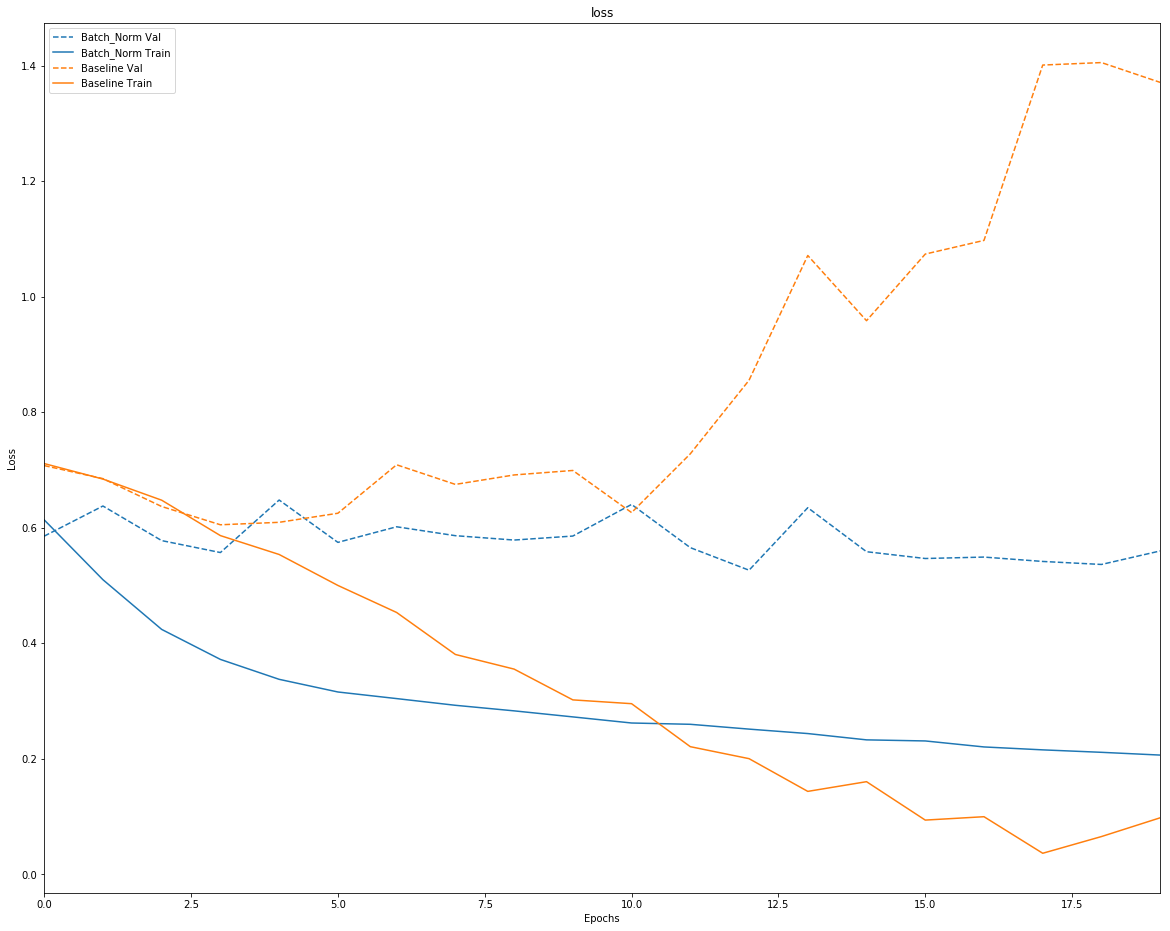

In [58]:
plot_histories([('batch_norm', hist_bn), 
                ('baseline', hist_base)], keys=['loss'])

## Using data augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

In [49]:
# now we need to set up a different input pipeline that does the augmentation for us
train_datagen_aug = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 2000 images belonging to 2 classes.


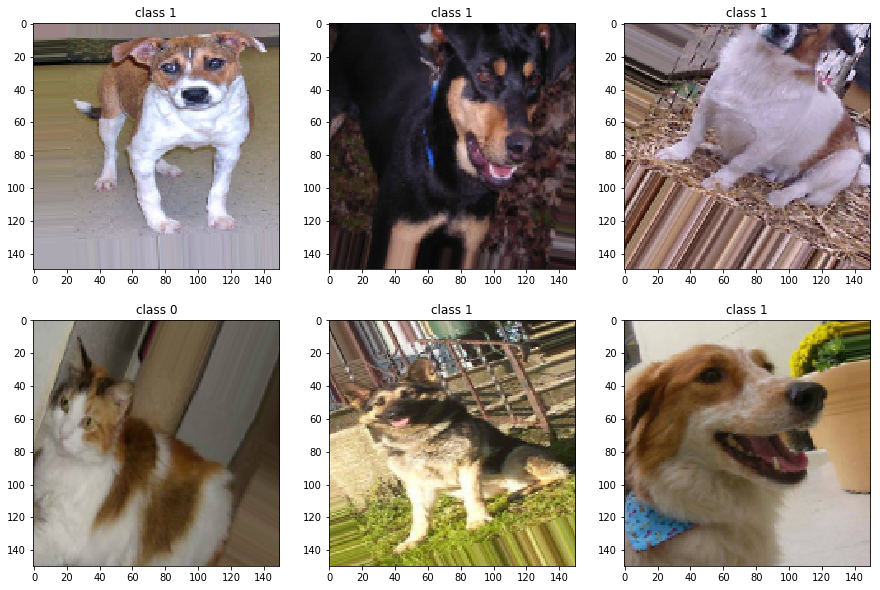

In [50]:
# plot some augmented images: on every execution you should get different images
img_batch, label_batch = train_generator_aug.next()
n_per_row = 3

plt.figure(figsize=(15, 10))
for i in range(n_per_row):
    plt.subplot(2, n_per_row, i + 1)
    plt.imshow(img_batch[i])
    plt.title("class " + str(int(label_batch[i])))

for i in range(n_per_row):
    plt.subplot(2, n_per_row, n_per_row + i + 1)
    plt.imshow(img_batch[n_per_row + i])
    plt.title("class " + str(int(label_batch[n_per_row + i])))
    
plt.show()

In [51]:
# during validation we do NOT augment the images of course
test_datagen_aug = ImageDataGenerator(rescale=1. / 255)
test_generator_aug = test_datagen_aug.flow_from_directory(
        validation_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels


Found 800 images belonging to 2 classes.


In [52]:
m_base = get_baseline_model()

m_base.compile(optimizer="rmsprop",
               loss="binary_crossentropy", 
               metrics=['accuracy'])

hist_aug = m_base.fit_generator(train_generator_aug,
                                epochs=epochs,
                                steps_per_epoch=2000 // batch_size,
                                validation_data=test_generator_aug,
                                validation_steps=800 // batch_size)

Epoch 1/20
31/31 [==============================] - 27s 858ms/step - loss: 0.7914 - acc: 0.5162 - val_loss: 0.7043 - val_acc: 0.4987
Epoch 2/20
31/31 [==============================] - 26s 833ms/step - loss: 0.6918 - acc: 0.5261 - val_loss: 0.6780 - val_acc: 0.5573
Epoch 3/20
31/31 [==============================] - 25s 810ms/step - loss: 0.6836 - acc: 0.5793 - val_loss: 0.6547 - val_acc: 0.6159
Epoch 4/20
31/31 [==============================] - 25s 797ms/step - loss: 0.6626 - acc: 0.5962 - val_loss: 0.6191 - val_acc: 0.6576
Epoch 5/20
31/31 [==============================] - 24s 788ms/step - loss: 0.6721 - acc: 0.6255 - val_loss: 0.6132 - val_acc: 0.6589
Epoch 6/20
31/31 [==============================] - 23s 748ms/step - loss: 0.6496 - acc: 0.6251 - val_loss: 0.6110 - val_acc: 0.6719
Epoch 7/20
31/31 [==============================] - 22s 725ms/step - loss: 0.6361 - acc: 0.6406 - val_loss: 0.5963 - val_acc: 0.6784
Epoch 8/20
31/31 [==============================] - 22s 712ms/step - 

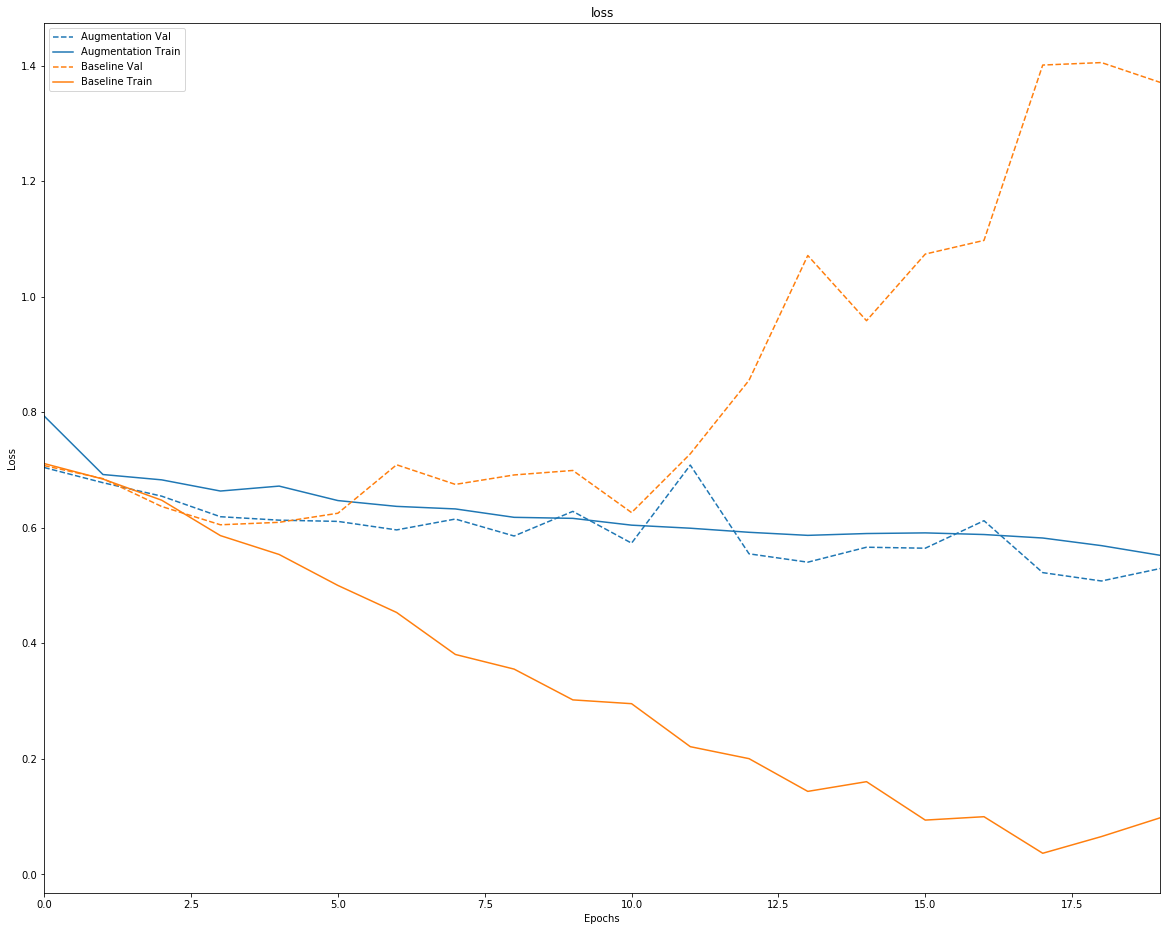

In [53]:
plot_histories([('augmentation', hist_aug),
                ('baseline', hist_base)], keys=["loss"])